In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import copy
import seaborn as sns
from PIL import Image

In [77]:
data_root = './squares'
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')


In [78]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize 224x224 images
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_for_analysis = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [89]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_augmentation)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_dataset_for_analysis = datasets.ImageFolder(train_dir, transform=transform_for_analysis)
val_dataset_for_analysis = datasets.ImageFolder(val_dir, transform=transform_for_analysis)

This function analyzes the characteristics of square images. It calculates and prints statistics about the size and color of squares in each class


Analyzing datasets...

--- Training Dataset Analysis ---

Class: a
Square size (pixels): mean=41.89, std=19.90, min=11, max=101
Average RGB: R=0.297, G=0.297, B=0.294

Class: b
Square size (pixels): mean=40.75, std=19.46, min=9, max=95
Average RGB: R=0.534, G=0.535, B=0.520

Class: c
Square size (pixels): mean=41.01, std=20.14, min=9, max=101
Average RGB: R=0.762, G=0.762, B=0.758


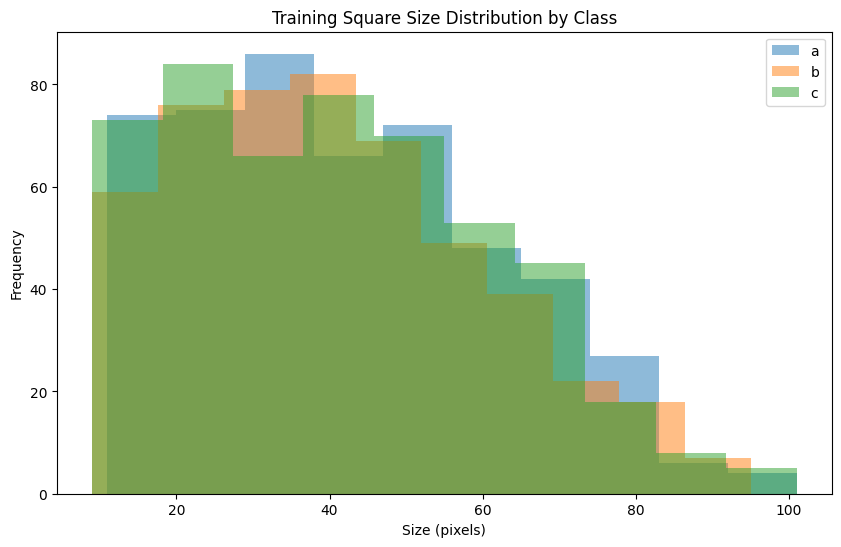

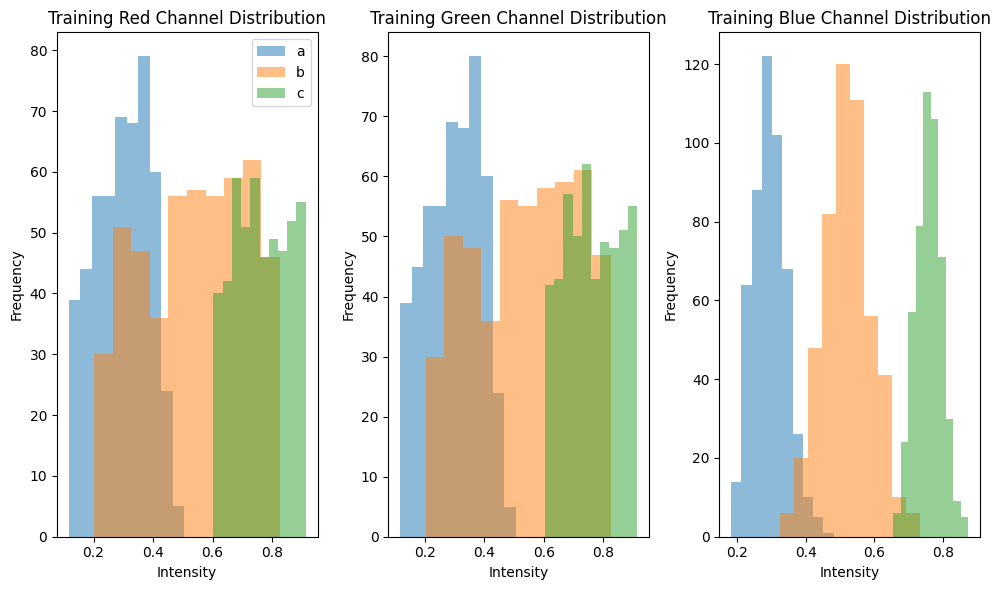


--- Validation Dataset Analysis ---

Class: a
Square size (pixels): mean=43.58, std=19.75, min=9, max=99
Average RGB: R=0.298, G=0.298, B=0.294

Class: b
Square size (pixels): mean=42.52, std=19.74, min=9, max=95
Average RGB: R=0.521, G=0.521, B=0.522

Class: c
Square size (pixels): mean=41.79, std=19.36, min=9, max=99
Average RGB: R=0.760, G=0.760, B=0.758


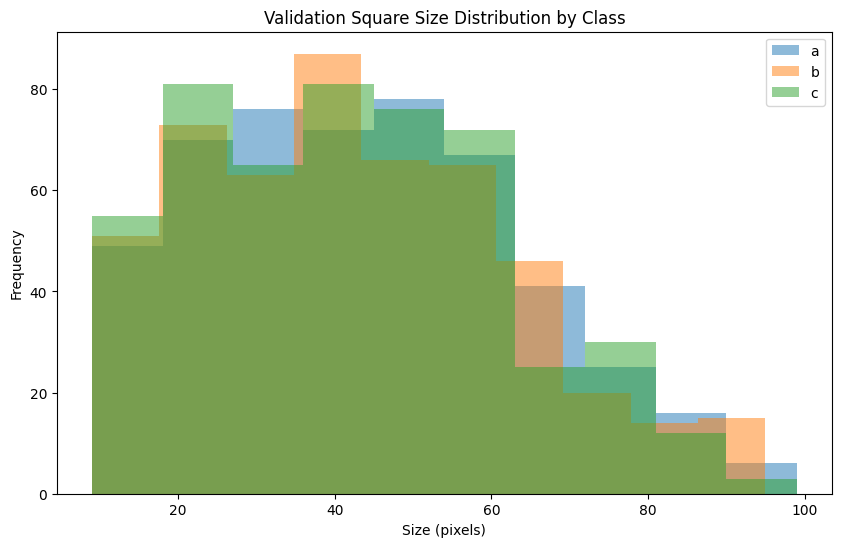

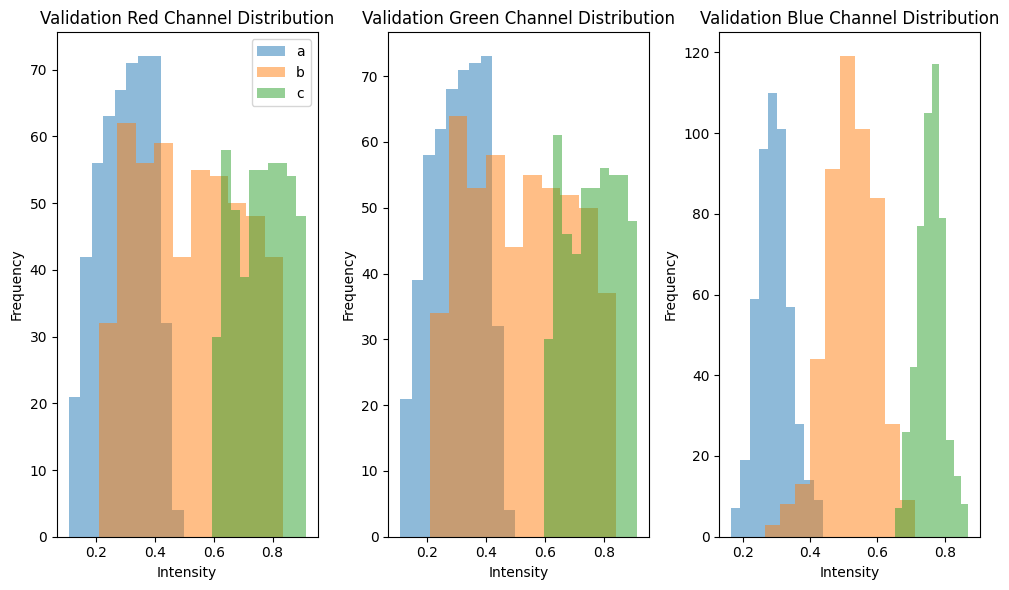

In [29]:
# Parameters:
#   dataset: The dataset to analyze (must be a torchvision dataset)
#   class_names: List of class names in the dataset
#   dataset_name: Name of the dataset for display purposes
#   output_suffix: Optional suffix for output file names

def analyze_dataset(dataset, class_names, dataset_name, output_suffix=""):
    print(f"\n--- {dataset_name} Dataset Analysis ---")
    
    # Collect statistics for each class
    class_stats = {cls: {'sizes': [], 'colors': []} for cls in class_names}
    
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        class_name = class_names[label]
        
        # Convert to numpy for analysis
        img_np = img.permute(1, 2, 0).numpy()
        
        # Find non-white pixels (assuming white background)
        gray = np.mean(img_np, axis=2)
        non_white = gray < 0.9
        
        if np.any(non_white):
            # Calculate bounding box
            y_indices, x_indices = np.where(non_white)
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            
            # Calculate square size
            width = x_max - x_min
            height = y_max - y_min
            size = max(width, height)
            class_stats[class_name]['sizes'].append(size)
            
            
            # Calculate average color of the square
            square_mask = non_white
            avg_color = np.mean(img_np[square_mask], axis=0)
            class_stats[class_name]['colors'].append(avg_color)
    
    # Calculate statistics for each class
    for cls in class_names:
        if class_stats[cls]['sizes']:
            print(f"\nClass: {cls}")
            
            # Size statistics
            sizes = np.array(class_stats[cls]['sizes'])
            print(f"Square size (pixels): mean={np.mean(sizes):.2f}, std={np.std(sizes):.2f}, min={np.min(sizes)}, max={np.max(sizes)}")
            
            # Color statistics
            colors = np.array(class_stats[cls]['colors'])
            print(f"Average RGB: R={np.mean(colors[:,0]):.3f}, G={np.mean(colors[:,1]):.3f}, B={np.mean(colors[:,2]):.3f}")

    
    # Plot size distributions
    plt.figure(figsize=(10, 6))
    for cls in class_names:
        if class_stats[cls]['sizes']:
            plt.hist(class_stats[cls]['sizes'], alpha=0.5, label=cls)
    plt.title(f'{dataset_name} Square Size Distribution by Class')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(os.path.join(img_dir, f'{output_suffix}class_size_distribution.png'))
    plt.show()
    plt.close()
    
    # Plot color distributions
    plt.figure(figsize=(10, 6))
    for i, color_channel in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i+1)
        for cls in class_names:
            if class_stats[cls]['colors']:
                colors = np.array(class_stats[cls]['colors'])
                plt.hist(colors[:, i], alpha=0.5, label=cls)
        plt.title(f'{dataset_name} {color_channel} Channel Distribution')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(img_dir, f'{output_suffix}class_color_distribution.png'))
    plt.show()
    plt.close()
    

output_dir = 'outputs'
img_dir = os.path.join(output_dir, 'images')


print("\nAnalyzing datasets...")

analyze_dataset(train_dataset_for_analysis, train_dataset.classes, "Training", "train_")
analyze_dataset(val_dataset_for_analysis, val_dataset.classes, "Validation", "val_")

# Training function

In [90]:

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, cm

# Evaluation function

In [91]:

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, cm, all_preds, all_labels

In [ ]:
# Grid search completed!
# Best parameter combination: batch_size=32, learning_rate=0.0005, num_epochs=100
# Best validation accuracy: 0.9833

# HyperParameters

In [92]:
batch_size = 32
num_epochs = 100
learning_rate = 0.0005
model_dir = os.path.join(output_dir, 'models')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [93]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create model instance
model = models.resnet18(weights='IMAGENET1K_V1')
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Process

In [94]:
# Create lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []


# Training loop
print(f"\nTraining on {device}")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc, train_cm = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    if epoch % 20 == 0:
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Evaluate
    val_loss, val_acc, val_cm, all_preds, all_labels = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if epoch % 20 == 0:
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



Training on cuda


Training: 100%|██████████| 47/47 [00:03<00:00, 13.87it/s]



Epoch 1/100
Training Loss: 0.3897, Training Accuracy: 0.8453


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 22.09it/s]


Validation Loss: 0.7976, Validation Accuracy: 0.8647


Training: 100%|██████████| 47/47 [00:03<00:00, 13.65it/s]



Epoch 21/100
Training Loss: 0.0446, Training Accuracy: 0.9820


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 21.68it/s]


Validation Loss: 0.0750, Validation Accuracy: 0.9800


Training: 100%|██████████| 47/47 [00:03<00:00, 13.87it/s]



Epoch 41/100
Training Loss: 0.0547, Training Accuracy: 0.9780


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 22.38it/s]


Validation Loss: 0.0750, Validation Accuracy: 0.9800


Training: 100%|██████████| 47/47 [00:03<00:00, 13.72it/s]



Epoch 61/100
Training Loss: 0.0289, Training Accuracy: 0.9893


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 22.44it/s]


Validation Loss: 0.0739, Validation Accuracy: 0.9793


Training: 100%|██████████| 47/47 [00:03<00:00, 13.72it/s]



Epoch 81/100
Training Loss: 0.0208, Training Accuracy: 0.9900


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 22.13it/s]


Validation Loss: 0.0879, Validation Accuracy: 0.9820


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 22.04it/s]


<Figure size 800x600 with 0 Axes>

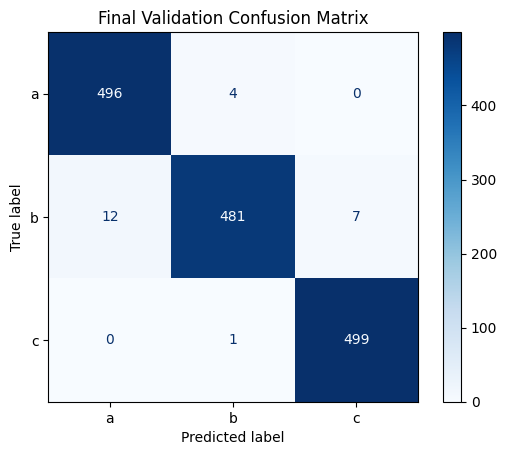

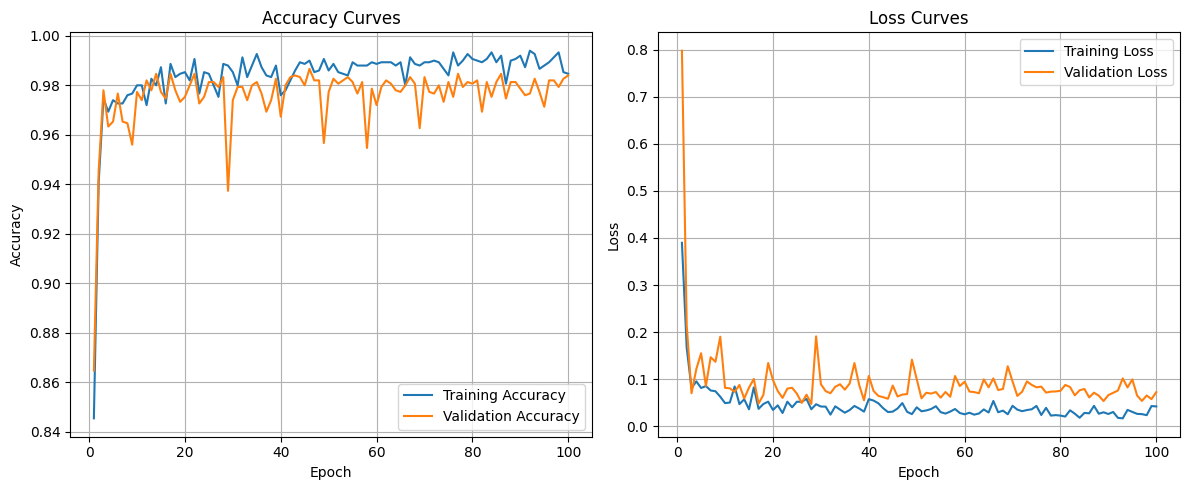

Model saved successfully at outputs/models/resnet_squares_classifier.pth!


In [95]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=val_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Final Validation Confusion Matrix')
plt.savefig(os.path.join(img_dir, 'final_confusion_matrix.png'))
plt.show()
plt.close()

# Plot training and validation curves
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'accuracy_loss_curves.png'))
plt.show()
plt.close()

# Save the model
model_path = os.path.join(model_dir, 'resnet_squares_classifier.pth')
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}!")

# Evaluation

/mnt/tmp/ipykernel_492252/1876802662.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))


Weighted F1 Score: 0.9839


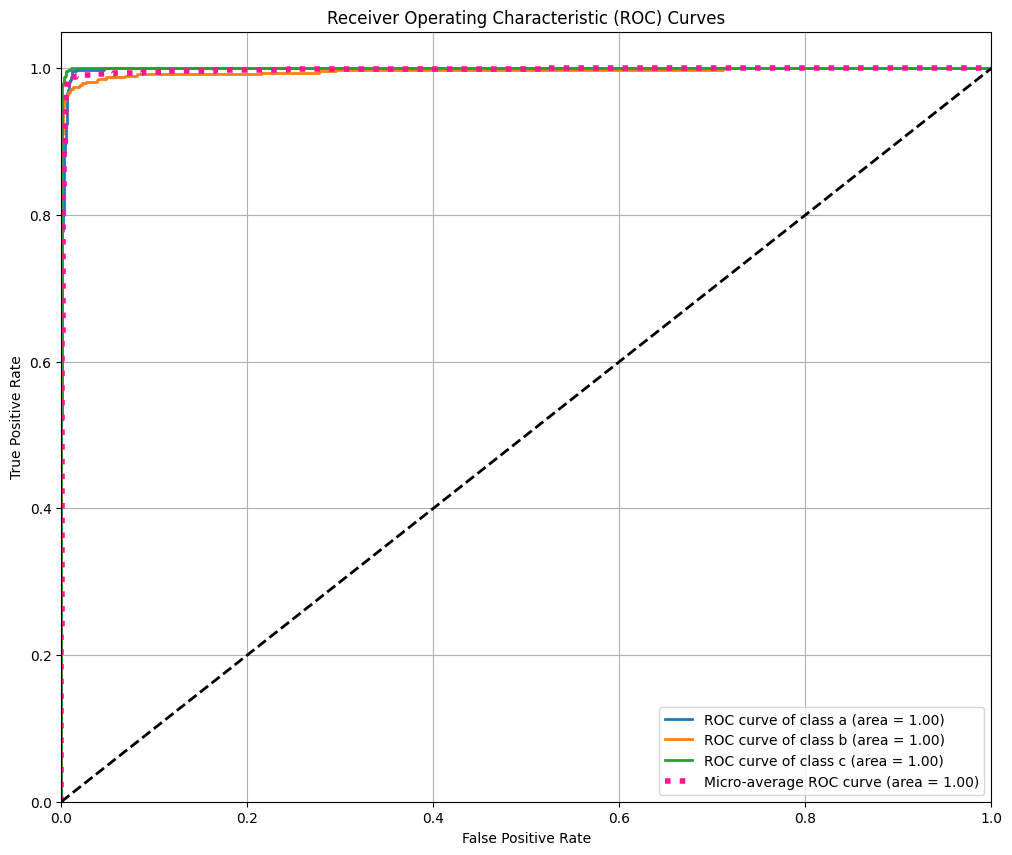


F1 Score per Class:
a: 0.9841
b: 0.9757
c: 0.9920


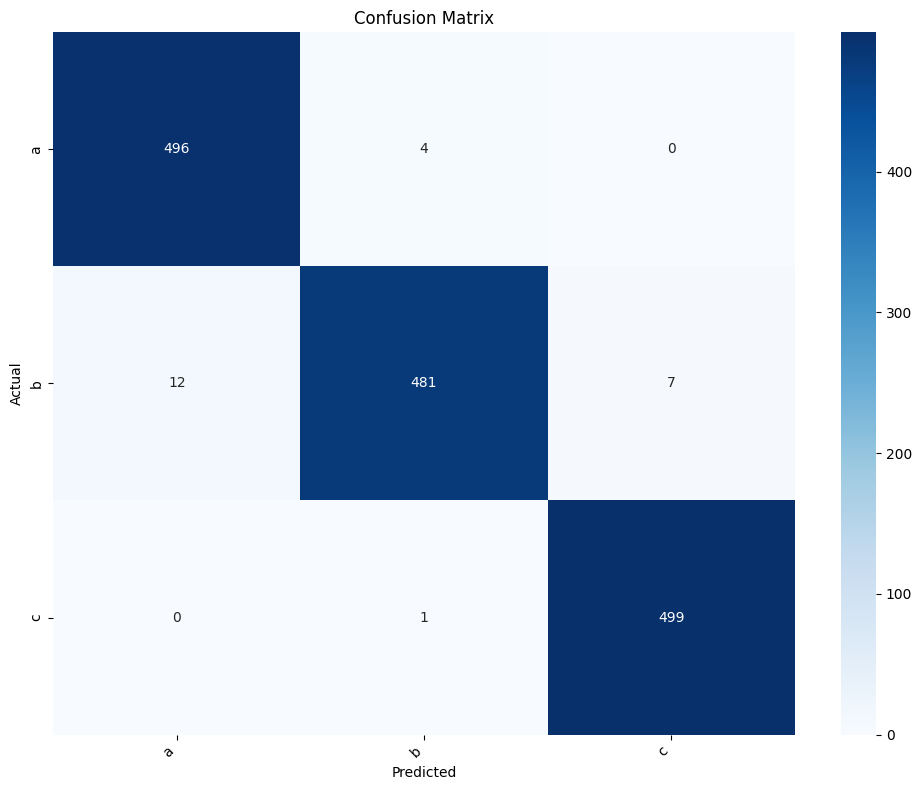

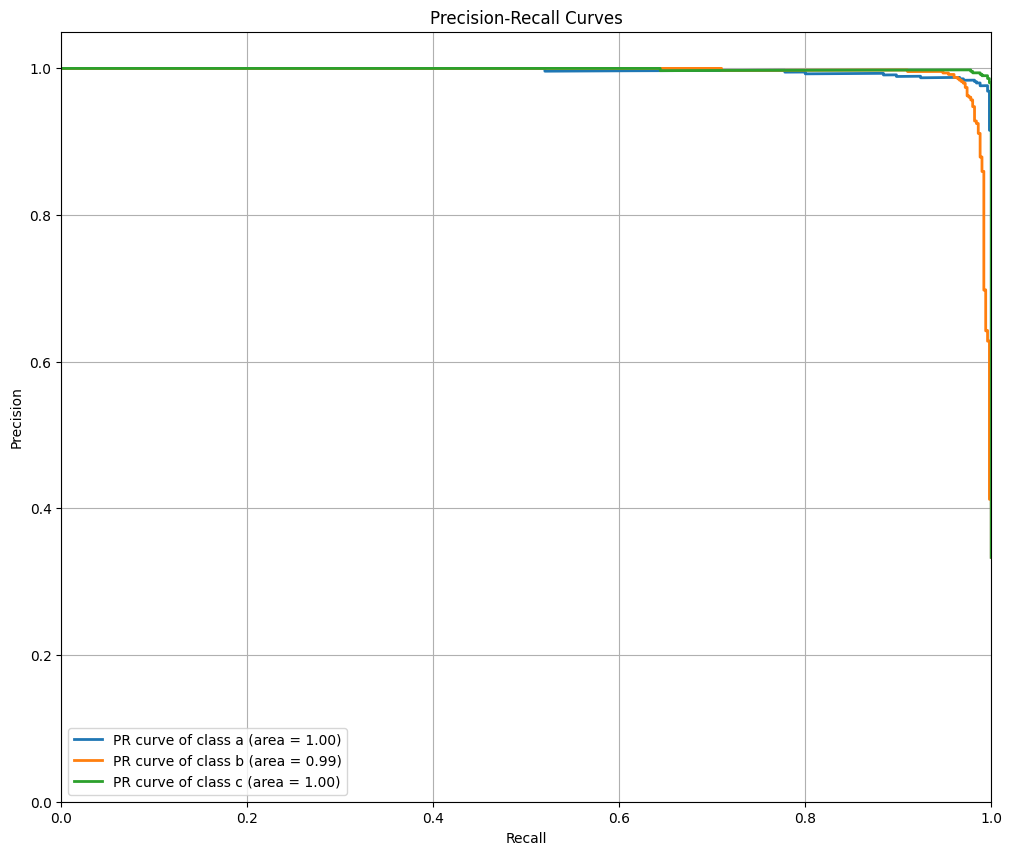


Performance Summary:
Overall Weighted F1 Score: 0.9839
Micro-average AUC: 0.9975

F1 Score per Class:
a: 0.9841
b: 0.9757
c: 0.9920

AUC per Class:
a: 0.9986
b: 0.9958
c: 0.9996


In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize

# 1. Load the saved model
# If you already have a best_model variable, you can use it directly
# Otherwise, load the model from the saved path
model_path = os.path.join(model_dir, 'resnet_squares_classifier.pth')
best_model = models.resnet18(num_classes=len(train_dataset.classes))
best_model.load_state_dict(torch.load(model_path))
best_model = best_model.to(device)

# Make sure the model is in evaluation mode
best_model.eval()

# 2. Collect predictions and labels
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = best_model(inputs)
        
        # Get predicted classes
        _, preds = torch.max(outputs, 1)
        
        # Get prediction probabilities (apply softmax)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        # Store results
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# 3. Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# 4. Calculate and plot AUC (for multi-class problems)
# One-hot encode the labels
n_classes = len(train_dataset.classes)
labels_one_hot = label_binarize(all_labels, classes=np.arange(n_classes))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))

# Calculate ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve
    plt.plot(fpr[i], tpr[i], lw=2, 
             label=f'ROC curve of class {train_dataset.classes[i]} (area = {roc_auc[i]:.2f})')

# Calculate micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot random guess baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 5. Calculate F1 score for each class
# Calculate F1 score for each class
f1_per_class = f1_score(all_labels, all_preds, average=None)

# Print F1 score for each class
print("\nF1 Score per Class:")
for i, cls in enumerate(train_dataset.classes):
    print(f"{cls}: {f1_per_class[i]:.4f}")

# 6. Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Calculate and plot Precision-Recall curves
plt.figure(figsize=(12, 10))

# Calculate PR curve for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(labels_one_hot[:, i], all_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    
    # Plot PR curve
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {train_dataset.classes[i]} (area = {pr_auc[i]:.2f})')

# Set chart parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 8. Summarize performance metrics
print("\nPerformance Summary:")
print(f"Overall Weighted F1 Score: {f1:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print("\nF1 Score per Class:")
for i, cls in enumerate(train_dataset.classes):
    print(f"{cls}: {f1_per_class[i]:.4f}")
print("\nAUC per Class:")
for i, cls in enumerate(train_dataset.classes):
    print(f"{cls}: {roc_auc[i]:.4f}")